In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [325]:
with open('/Users/andrewpeters/GitHub/fpl/data/processed/X_forward_rolling.npy', 'rb') as file:
    X = np.load(file, allow_pickle=True)
with open('/Users/andrewpeters/GitHub/fpl/data/processed/y_forward_rolling.npy', 'rb') as file:
    y = np.load(file)
with open('/Users/andrewpeters/GitHub/fpl/data/processed/metadata_forward_rolling.npy', 'rb') as file:
    metadata = np.load(file, allow_pickle=True)

In [326]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [327]:
from helpers import score_model

In [328]:
import xgboost as xgb

In [329]:
X_train, X_test, y_train, y_test, metadata_train, metadata_test = train_test_split(X, y, metadata, test_size=0.25, random_state=42)

In [330]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

In [331]:
X_test = scaler.transform(X_test)

In [332]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 30, seed = 123, max_depth = 6)
xgb_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=30, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [333]:
y_predicted = xgb_reg.predict(X_test)

In [352]:
results_df = score_model(predictions = y_predicted, y_test = y_test)

Overall Score is: 3.6624937123660364
MAE over the entire dataset is: 3.7296704592276826
MAE when a player earns more than 5pts is: 3.6289053389352133


In [340]:
#with open ('/Users/andrewpeters/GitHub/fpl/models/xgb_forward_rolling_232.pkl', 'wb') as file: #filename = model + score
    pickle.dump(xgb_reg, file)

In [341]:
#with open ('/Users/andrewpeters/GitHub/fpl/models/min_max_scaler_foward_rolling.pkl', 'wb') as file: #filename = model + score
    pickle.dump(scaler, file)

# show learning curve

In [342]:
#Assess if model is improving more data
m = len(X_train)
index = np.arange(0, m)
permu = np.random.permutation(m)
num_samples = 20
rmse_train_list = []
rmse_test_list = []
rmse_test_over5_list = []

for sample in np.arange(1,num_samples):
    num_rows = round((m/num_samples)*sample)
    to_keep = permu[:num_rows]
    X_train_reduced = X_train[(to_keep), :]
    y_train_reduced = y_train[to_keep]
    model = xgb_reg.fit(X_train_reduced, y_train_reduced)
    rmse_train = np.sqrt(mean_squared_error(model.predict(X_train_reduced), y_train_reduced))
    rmse_test = np.sqrt(mean_squared_error(model.predict(X_test), y_test))
    rmse_test_over5 = np.sqrt(mean_squared_error(model.predict(X_test[y_test > 5]), y_test[y_test > 5]))
    rmse_train_list.append(float(rmse_train))
    rmse_test_list.append(float(rmse_test))
    rmse_test_over5_list.append(float(rmse_test_over5))

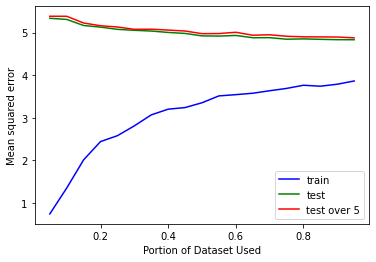

In [343]:
plt.plot(np.arange(1, num_samples)/num_samples, rmse_train_list, color = 'blue', label = 'train')
plt.plot(np.arange(1, num_samples)/num_samples, rmse_test_list, color = 'green', label = 'test')
plt.plot(np.arange(1, num_samples)/num_samples, rmse_test_over5_list, color = 'red', label = 'test over 5')
plt.xlabel('Portion of Dataset Used')
plt.ylabel('Mean squared error')
plt.legend()